In [17]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
import os
import seaborn as sns
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans, vq, kmeans2
from scipy.spatial.distance import euclidean,cdist


In [18]:
#define function that cleans the dataset

def clean_data(df):
    
    #drop columns with more than 50 empty columns
    
    df.dropna(axis=1,thresh=50, inplace=True)

    #drop the indicator name,code variables as they aren't noisy

    df.drop(["Indicator Name", "Indicator Code"], axis=1,inplace=True)

    #drop rows with more than 12 missing years
    df.dropna(axis=0,thresh=12, inplace=True)

    # fill empty values with linear interpolation country by country
    df.iloc[:,2:]= df.iloc[:,2:].interpolate(method='linear', limit_direction='forward', axis=1)
    #drop values before 2000
    try:
        df=pd.concat([df.iloc[:,:2],df.loc[:,'2000':]],axis=1)
        
    except Exception:
        pass
    df.reset_index(drop=True,inplace=True)
    return df

In [19]:
#function to left join df with the income/region metadata and separate them into 2 different dfs country and region

# left join the 2 dataframes
def separate_df(data_df, metadata_df):
    
    combined_df= pd.merge(data_df,metadata_df, on='Country Code', how='left')
    
    # seperate countries and regions in 2 different dataframes
    
    country_df = combined_df[combined_df["Region"].notna()]
    region_df = combined_df[combined_df["Region"].isna()]
    
    region_df.drop(["Region", "IncomeGroup"], axis=1, inplace=True)
    
    return country_df, region_df

In [20]:
#define function to create dummies for given column and remove it from df

def create_dummies(df,col_name):
    
    #turn column into dummies
    
    enc = pd.get_dummies( df[col_name])
    
    #join dummies at the end of df
    
    df = pd.concat([df, enc], axis=1)
    
    #drop original column from df
    
    df.drop(col_name,axis=1,inplace=True)
    
    return df

In [21]:
#define a function to breakdown the GDP investment df into subcategories

def separate_inv(inv_df, ind, value_i, sub_ind, value_s):

#select indicator to be split
    split_1 = inv_df[inv_df[ind] == value_i]

#select sub-indicator to be split
    split_2 = split_1[split_1[sub_ind] == value_s]

#drop indicator/subindicator columns
    split_2.drop(ind,axis=1,inplace=True)
    split_2.drop(sub_ind,axis=1,inplace=True)

    return split_2

In [22]:
def unpivot(df, L, cl_var_name, cl_value_name):
    """
    This function returns unpivoted dataframe. 
    L: list of the static columns name.
    var_name: new name for the new columns of unpivoted columns (first row). 
    value_name: new name for the new columns of unpivoted values (second to last rows).
    """
    
    # Check if first introduced object is a dataframe
    if not isinstance(df, pd.DataFrame):
        print("The first introduced argument should be a dataframe.")
        return None

    # Check if the second introduced object is a list
    if not isinstance(L, list):
        print("The second introduced argument should be a list.")
        return None

    # Check if the third introduced object is a string value
    if not isinstance(cl_var_name, str):
        print("The third introduced argument should be a string value.")
        return None

    # Check if the fourth introduced object is a string value
    if not isinstance(cl_var_name, str):
        print("The fourth introduced argument should be a string value.")
        return None

    # Unpivot dataframe
    unpivoted_df = df.melt(id_vars=L,
                           var_name=cl_var_name,
                           value_name=cl_value_name)
    return unpivoted_df

In [23]:
#define a function to fill in missing values in each column using kmean regressor
def kmeans_fillna (df,X,y,y_pred):

#select the variable to be predicted
    dependent = df[y]

#select the other variables to be used in the regressor for prediction and fill in their missing values with respective averages
#(avg fillna applied because kmeans regressor doesn't work with variables that have missing values)
    tempavg = df[X].fillna(df.mean())

#merge the two tables together for analysis
    reg = pd.concat([dependent,tempavg],axis=1).apply(pd.to_numeric)

#splitting the reg dataframe to incomplete table 
#contains the rows of each Nan value of the dependent variable in reg df
    incomplete = reg[reg[y].isna()]
    
#splitting the reg dataframe to complete table 
#contains the rows of each valid value of the dependent variable in reg df
    complete = reg[~reg.index.isin(incomplete.index)]

#setting the kmeans regressor using euclidean distances
    regressor = KNeighborsRegressor(10,weights = 'distance',metric = 'euclidean')

#applying the regressor to the dataframe
    fitting = regressor.fit(complete.loc[:,X],complete.loc[:,[y]])
    
#predicting the values in the incomplete table 
    incomplete[y_pred] = fitting.predict(incomplete.drop(columns=[y]))

#cleaning the incomplete df and getting ready to merge back to the original dataframe
    incomplete.drop(X,axis=1,inplace=True)
    incomplete.drop(y,axis=1,inplace=True)

#applying concatenate to the original df
    df = pd.concat([df,incomplete],axis=1)

#fillna of dependent and predicted columns with 0, to be able to add back to the original df
    df[[y,y_pred]] = df[[y,y_pred]].fillna(0)

#add the new values to the original column in the original df
    df[y] = df[y] + df[y_pred] 

#drop the predicted column from the original df
    df.drop(columns=[y_pred],inplace=True)

#return the original df
    return df

In [24]:
# import expenditure data from csv and clean data 

receipt_df = pd.read_csv(os.path.join(os.getcwd(), 'API_ST.INT.RCPT.CD_DS2_en_csv_v2_259854.csv'), skiprows=4)
receipt_df = clean_data(receipt_df)
receipt_df.columns

Index(['Country Name', 'Country Code', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017'],
      dtype='object')

In [25]:
#import international inbound tourist data from csv and clean the data
tourist_df=pd.read_csv(os.path.join(os.getcwd(),"API_ST.INT.ARVL_DS2_en_csv_v2_103871.csv"), skiprows=4)
tourist_df = clean_data(tourist_df)

In [26]:
#import Start-up procedures to register a business data from csv and clean the data
startup_df = pd.read_csv(os.path.join(os.getcwd(),"Start-up procedures to register a business.csv"),skiprows =4)
startup_df = clean_data(startup_df)
startup_df.head()

,Country Name,Country Code,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,AFG,NaN,4.0000,4.000000,4.000000,5.00,5.00,5.0,5.0,5.00,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
1,Angola,AGO,12.000000,12.0000,12.000000,12.000000,12.00,8.00,8.0,8.0,8.00,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
2,Albania,ALB,12.000000,12.0000,12.000000,12.000000,11.00,8.00,6.0,6.0,6.00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
3,Arab World,ARB,12.307692,11.6875,11.333333,11.333333,10.45,9.55,9.3,9.4,9.25,9.142857,8.904762,8.714286,8.590909,8.363636,7.863636,7.181818
4,United Arab Emirates,ARE,10.000000,10.0000,10.000000,10.000000,9.00,9.00,8.0,8.0,7.00,6.000000,6.000000,6.000000,6.000000,4.000000,4.000000,2.000000


In [27]:
# import country region and income information
country_info = pd.read_csv(os.path.join(os.getcwd(),"Metadata_Country_API_ST.INT.ARVL_DS2_en_csv_v2_103871.csv"), usecols=[0,1,2])
country_info.head()

,Country Code,Region,IncomeGroup
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income


In [28]:
# import GDP and investment information
investment_GDP_df = pd.read_csv(os.path.join(os.getcwd(),"Public_Private Spending on travel and Tourism service.csv"))
investment_GDP_df = investment_GDP_df.rename(columns={'Country ISO3': 'Country Code'})
#drop columns with more than 50 empty rows
investment_GDP_df.dropna(axis=1,thresh=50, inplace=True)

investment_GDP_df.drop(["Indicator Id"], axis=1,inplace=True)
#drop rows with more than 12 empty columns
investment_GDP_df.dropna(axis=0,thresh=12, inplace=True)
#drop years 2020 and onwards
investment_GDP_df.drop(investment_GDP_df.iloc[:,-9:], axis=1,inplace=True)
#fill empty values with interpolation row by row
investment_GDP_df.iloc[:,4:]= investment_GDP_df.iloc[:,4:].interpolate(method='linear', limit_direction='forward', axis=1)
#drop values before 2000
try:
    investment_GDP_df=pd.concat([investment_GDP_df.iloc[:,:4],investment_GDP_df.loc[:,'2000':]],axis=1)

except Exception:
    pass
investment_GDP_df.reset_index(drop=True,inplace=True)
investment_GDP_df.head()

,Country Code,Country Name,Indicator,Subindicator Type,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,ABW,Aruba,Government spending on travel and Tourism service,US$ in bn (Real prices),0.010000,0.010000,0.01000,0.010000,0.010000,0.010000,...,0.01000,0.010000,0.020000,0.020000,0.020000,0.010000,0.020000,0.020000,0.020000,0.020000
1,ABW,Aruba,Government spending on travel and Tourism service,% share of total tourism expenditure,15.914900,16.017300,16.13450,16.182600,16.246800,16.331100,...,16.76000,16.847100,16.934700,17.022700,17.111100,17.200000,17.289400,17.379200,17.469500,17.560300
2,ABW,Aruba,Capital investment in Travel and Tourism,US$ in bn (Real prices),0.153693,0.109398,0.09000,0.107927,0.158663,0.249757,...,0.23232,0.216569,0.203147,0.193966,0.190947,0.188123,0.192187,0.193334,0.196801,0.200177
3,ABW,Aruba,Travel and Tourism total contribution to GDP,Percentage share of total GDP,60.923700,57.094400,57.09640,55.914000,57.475600,59.803200,...,78.91120,71.982300,81.969600,85.277200,88.783500,88.683400,89.923400,86.518400,85.600000,86.595400
4,ABW,Aruba,Travel and Tourism total contribution to GDP,US$ in bn (Real prices),1.654920,1.504890,1.45546,1.453850,1.612710,1.698370,...,1.98278,1.872820,2.103450,2.280200,2.394090,2.393550,2.407880,2.360870,2.389410,2.456100


In [29]:
GDP_pct = separate_inv(investment_GDP_df,"Indicator",'Travel and Tourism total contribution to GDP','Subindicator Type','Percentage share of total GDP')

GDP_govt = separate_inv(investment_GDP_df,"Indicator",'Government spending on travel and Tourism service','Subindicator Type',"US$ in bn (Real prices)")

GDP_govt_pct = separate_inv(investment_GDP_df,"Indicator",'Government spending on travel and Tourism service','Subindicator Type',"% share of total tourism expenditure")

GDP_cap = separate_inv(investment_GDP_df,"Indicator",'Capital investment in Travel and Tourism','Subindicator Type',"US$ in bn (Real prices)")

GDP_pct.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Country Code,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
3,ABW,Aruba,60.92370,57.09440,57.09640,55.91400,57.47560,59.80320,60.16850,62.62210,...,78.91120,71.98230,81.96960,85.27720,88.78350,88.68340,89.9234,86.51840,85.60000,86.59540
8,AGO,Angola,1.99362,1.93643,2.76941,3.01094,3.58121,3.42679,3.24902,4.20504,...,3.92187,3.27314,3.96158,4.38231,4.28051,4.24098,3.6797,3.80397,3.84565,3.87318
13,ALB,Albania,17.30970,18.41520,21.18670,19.96460,19.18770,21.14070,22.33050,24.46910,...,23.91040,22.98380,24.95270,23.41440,24.77550,24.71080,26.0856,26.16730,26.33710,26.27060
18,ARE,United Arab Emirates,4.17632,4.12760,4.17576,3.84759,3.62198,5.21594,6.00355,6.65776,...,8.27160,7.92635,7.90240,8.83063,8.56885,10.37290,11.1482,11.33290,11.23410,10.78570
23,ARG,Argentina,9.75165,9.78442,12.33670,10.65860,11.81330,13.93200,14.46460,14.61570,...,11.92890,11.20390,10.64860,10.27430,9.99388,9.55704,10.1034,10.25440,10.29390,10.18480


In [30]:
population = pd.read_csv(os.path.join(os.getcwd(),'Population by country.csv'), encoding="ISO-8859-1",skiprows=4)
population = clean_data(population)
population.head()

,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,90853.0,92898.0,94992.0,97017.0,98737.0,100031.0,100834.0,101222.0,...,101455.0,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0
1,Afghanistan,AFG,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,...,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0
2,Angola,AGO,16395473.0,16945753.0,17519417.0,18121479.0,18758145.0,19433602.0,20149901.0,20905363.0,...,22514281.0,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0
3,Albania,ALB,3089027.0,3060173.0,3051010.0,3039616.0,3026939.0,3011487.0,2992547.0,2970017.0,...,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0
4,Andorra,AND,65390.0,67341.0,70049.0,73182.0,76244.0,78867.0,80993.0,82684.0,...,84463.0,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0


In [31]:
# Using unpivot function
unpivot_pop = unpivot(population, ['Country Name', 'Country Code'], 'Year', 'Population')
unpivot_receipt = unpivot(receipt_df, ['Country Name', 'Country Code'], 'Year', 'Receipt')
unpivot_tourist = unpivot(tourist_df, ['Country Name', 'Country Code'], 'Year', 'TouristNumber')
unpivot_startup = unpivot(startup_df, ['Country Name', 'Country Code'], 'Year', 'StartupSteps')
unpivot_GDP_pct = unpivot(GDP_pct, ['Country Name', 'Country Code'], 'Year', 'GDPpct')
unpivot_GDP_govt = unpivot(GDP_govt, ['Country Name', 'Country Code'], 'Year', 'GDPgovt')
unpivot_GDP_govt_pct = unpivot(GDP_govt_pct, ['Country Name', 'Country Code'], 'Year', 'GDPgovtpct')
unpivot_GDP_cap = unpivot(GDP_cap, ['Country Name', 'Country Code'], 'Year', 'GDPcap')
dfs=[unpivot_tourist,unpivot_receipt,unpivot_pop,unpivot_startup,unpivot_GDP_pct,unpivot_GDP_govt,unpivot_GDP_govt_pct,unpivot_GDP_cap]
merged_df = reduce(lambda left,right: pd.merge(left, right, on=['Country Name', 'Country Code','Year'], how='left'), dfs)
merged_df['Year'] = pd.to_datetime(merged_df.Year, format='%Y')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446 entries, 0 to 4445
Data columns (total 11 columns):
Country Name     4446 non-null object
Country Code     4446 non-null object
Year             4446 non-null datetime64[ns]
TouristNumber    4407 non-null float64
Receipt          4201 non-null float64
Population       4446 non-null float64
StartupSteps     3109 non-null float64
GDPpct           3132 non-null float64
GDPgovt          3132 non-null float64
GDPgovtpct       3132 non-null float64
GDPcap           3132 non-null float64
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 416.8+ KB


In [32]:
merged_country_df, merged_region_df = separate_df(merged_df, country_info)
merged_region_df.dropna(axis=1,thresh=40, inplace=True)
merged_country_df.head()
merged_country_df.Region.unique()

array(['Latin America & Caribbean', 'Sub-Saharan Africa',
       'Europe & Central Asia', 'Middle East & North Africa',
       'East Asia & Pacific', 'South Asia', 'North America'], dtype=object)

In [33]:
#test dummy function
country_dummies = create_dummies(country_info,col_name ='IncomeGroup')
country_dummies.head()

,Country Code,Region,High income,Low income,Lower middle income,Upper middle income
0,ABW,Latin America & Caribbean,1,0,0,0
1,AFG,South Asia,0,1,0,0
2,AGO,Sub-Saharan Africa,0,0,1,0
3,ALB,Europe & Central Asia,0,0,0,1
4,AND,Europe & Central Asia,1,0,0,0


In [34]:
#sort country data from highest

merged_country_df.sort_values("TouristNumber",inplace=True, ascending=False)

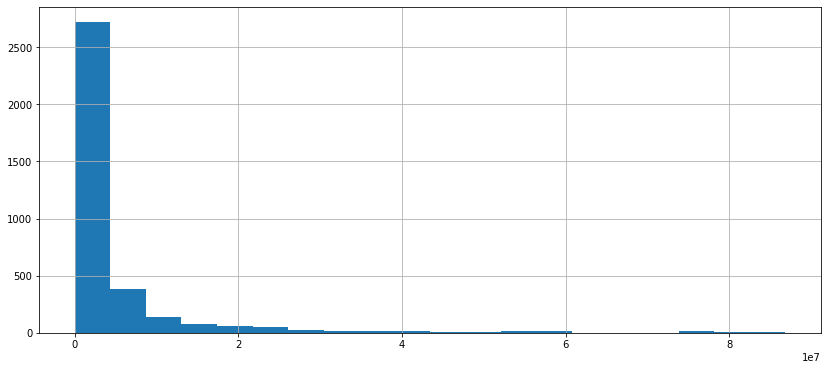

In [35]:
#plot histogram?
merged_country_df["TouristNumber"].hist(bins=20, figsize=[14,6])

In [36]:
#get all the values in the rows for Country Name
region_cols =merged_region_df['Country Name'].values

In [37]:
#seperate them according to specific words in the name
income_cols = [s for s in list(region_cols) if "income" in s]
dividend_cols =[s for s in list(region_cols) if "dividend" in s]
IDA_IBRD_cols =[s for s in list(region_cols) if ("IDA" in s or "IBRD" in s)]
not_classified_cols =[s for s in list(region_cols) if "not classified" in s]
organization_cols =[s for s in list(region_cols) if ("OECD members" in s or "Arab World" in s)]
small_states_cols =[s for s in list(region_cols) if "small states" in s]
other_cols =[s for s in list(region_cols) if ("Fragile and conflict affected situations" in s or "Heavily indebted poor countries (HIPC)" in s or "Least developed countries: UN classification" in s or "World" in s)]

In [38]:
#assign a classification to each list of names
def cond(x):
    if x in dividend_cols:
        return "Dividend" 
    elif x in IDA_IBRD_cols:
        return "IDA & IBRD" 
    elif x in income_cols:
        return "Income"
    elif x in not_classified_cols:
        return "Not Classified"
    elif x in organization_cols:
        return "Organization"
    elif x in small_states_cols:
        return "Small States"
    elif x in other_cols:
        return "Other"
    else:
        return "Group Region"
    return x

#assign classfication for every name in Country Name column
cat_col = [cond(x) for x in merged_region_df['Country Name']] 

#position we want to insert in df (3rd column)
idx = 2
#insert in existing df
merged_region_df.insert(loc=idx, column='Location Group', value=cat_col)
#show first 10 values to test it worked
merged_region_df.head(10)

,Country Name,Country Code,Location Group,Year,TouristNumber,Receipt,Population,StartupSteps
4,Arab World,ARB,Organization,2000-01-01,3.391257e+07,1.821374e+10,2.823442e+08,NaN
33,Central Europe and the Baltics,CEB,Group Region,2000-01-01,4.400000e+07,2.025500e+10,1.084478e+08,NaN
45,Caribbean small states,CSS,Small States,2000-01-01,4.991000e+06,5.520000e+09,6.513485e+06,NaN
57,East Asia & Pacific (excluding high income),EAP,Income,2000-01-01,6.284501e+07,4.297233e+10,1.816466e+09,NaN
58,Early-demographic dividend,EAR,Dividend,2000-01-01,9.124272e+07,6.103396e+10,2.472914e+09,NaN
59,East Asia & Pacific,EAS,Group Region,2000-01-01,1.050299e+08,9.277113e+10,2.047640e+09,NaN
60,Europe & Central Asia (excluding high income),ECA,Income,2000-01-01,5.036429e+07,1.546860e+10,3.923015e+08,NaN
61,Europe & Central Asia,ECS,Group Region,2000-01-01,3.830515e+08,2.638537e+11,8.619934e+08,NaN
64,Euro area,EMU,Group Region,2000-01-01,2.552200e+08,1.821727e+11,3.213108e+08,NaN
69,European Union,EUU,Group Region,2000-01-01,3.248400e+08,2.381857e+11,4.882211e+08,NaN


In [39]:
merged_country_df.isna().sum()

Country Name        0
Country Code        0
Year                0
TouristNumber      39
Receipt           209
Population          0
StartupSteps     1199
GDPpct            486
GDPgovt           486
GDPgovtpct        486
GDPcap            486
Region              0
IncomeGroup         0
dtype: int64

In [40]:
merged_country_df.describe()

,TouristNumber,Receipt,Population,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
count,3.579000e+03,3.409000e+03,3.618000e+03,2419.000000,3132.000000,3132.000000,3132.000000,3132.000000
mean,4.682152e+06,5.430363e+09,3.329045e+07,8.398098,13.483101,0.275747,4.639828,3.818893
std,1.064007e+07,1.582157e+10,1.304300e+08,3.405321,13.199727,1.316201,5.204974,14.677104
min,1.100000e+03,1.000000e+05,9.394000e+03,1.000000,0.778038,0.000000,-0.010000,0.000000
25%,2.235000e+05,1.560000e+08,8.187960e+05,6.000000,6.225903,0.000000,1.382788,0.090000
50%,8.920000e+05,7.620000e+08,6.070926e+06,8.000000,9.192615,0.020000,2.885920,0.343291
75%,3.970000e+06,3.985000e+09,2.081791e+07,11.000000,14.807200,0.090000,5.742598,2.036985
max,8.686100e+07,2.513610e+11,1.386395e+09,21.000000,98.471100,18.309200,29.040500,192.221000


In [41]:
merged_country_df['GDPgovt'] = merged_country_df['GDPgovt'].apply(lambda x:x*10**6)
merged_country_df['GDPcap'] = merged_country_df['GDPcap'].apply(lambda x:x*10**6)

In [42]:
#Tourist number
merged_country_df = kmeans_fillna(merged_country_df,["Population",'Receipt',"GDPpct","GDPgovt","GDPgovtpct","GDPcap"],"TouristNumber","TouristNumber1")
#Receipt
merged_country_df = kmeans_fillna(merged_country_df,["Population","TouristNumber","GDPgovt","GDPcap"],"Receipt","Receipt1")
#GDPpct
merged_country_df = kmeans_fillna(merged_country_df,["Population","GDPgovt","GDPgovtpct"],"GDPpct","GDPpct1")
#GDPgovt
merged_country_df = kmeans_fillna(merged_country_df,["Population",'Receipt',"GDPcap"],"GDPgovt","GDPgovt1")
#GDPgovtpct
merged_country_df = kmeans_fillna(merged_country_df,["Population","GDPpct"],"GDPgovtpct","GDPgovtpct1")
#startupsteps
merged_country_df = kmeans_fillna(merged_country_df,["Population","Receipt","GDPpct","GDPgovt","GDPgovtpct","GDPcap"],"StartupSteps","StartupSteps1")
#GDPcap
merged_country_df = kmeans_fillna(merged_country_df,["Population","GDPgovt"],"GDPcap","GDPcap1")
#population
#merged_country_df = kmeans_fillna(merged_country_df,["GDPcap","TouristNumber","Receipt","StartupSteps","GDPgovt","GDPgovtpct","GDPpct"],"Population","Population1")
merged_country_df.isnull().sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\s

Country Name     0
Country Code     0
Year             0
TouristNumber    0
Receipt          0
Population       0
StartupSteps     0
GDPpct           0
GDPgovt          0
GDPgovtpct       0
GDPcap           0
Region           0
IncomeGroup      0
dtype: int64

In [43]:
merged_country_df.describe()

,TouristNumber,Receipt,Population,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
count,3.618000e+03,3.618000e+03,3.618000e+03,3618.000000,3618.000000,3.618000e+03,3618.000000,3.618000e+03
mean,4.636063e+06,5.147743e+09,3.329045e+07,8.391559,15.512749,2.397323e+05,6.027857,3.323481e+06
std,1.059185e+07,1.540357e+10,1.304300e+08,2.991194,14.481207,1.228003e+06,6.977339,1.371341e+07
min,1.100000e+03,1.000000e+05,9.394000e+03,1.000000,0.778038,0.000000e+00,-0.010000,0.000000e+00
25%,2.202500e+05,1.360173e+08,8.187960e+05,6.148311,6.614410,0.000000e+00,1.636735,7.000000e+04
50%,8.760000e+05,7.020000e+08,6.070926e+06,8.000000,10.023000,1.415401e+04,3.169540,2.586805e+05
75%,3.832500e+06,3.441000e+09,2.081791e+07,10.000000,18.993100,7.000000e+04,7.585953,1.451760e+06
max,8.686100e+07,2.513610e+11,1.386395e+09,21.000000,98.471100,1.830920e+07,29.040500,1.922210e+08


In [44]:
#filter data over more than 1 Quartile for both number of tourists and volume of tourism receipts
filtereddata=merged_country_df[merged_country_df['TouristNumber']>= 0.2*10**6]
filtereddata=filtereddata[filtereddata['Receipt']>= 135*10**6]
filtereddata.describe()

,TouristNumber,Receipt,Population,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
count,2.522000e+03,2.522000e+03,2.522000e+03,2522.000000,2522.000000,2.522000e+03,2522.000000,2.522000e+03
mean,6.568721e+06,7.342526e+09,4.381919e+07,8.189336,15.858568,3.426135e+05,5.531869,4.724486e+06
std,1.218935e+07,1.801409e+10,1.543897e+08,3.082824,14.951913,1.458978e+06,6.503348,1.622721e+07
min,2.010000e+05,1.350000e+08,2.031100e+04,1.000000,1.135610,0.000000e+00,-0.010000,4.963574e+03
25%,7.127500e+05,6.202500e+08,2.319892e+06,6.000000,7.313685,1.000000e+04,1.406905,1.779035e+05
50%,1.919000e+06,1.735000e+09,8.900892e+06,8.000000,10.271600,3.875168e+04,3.111550,6.349065e+05
75%,6.552250e+06,6.682250e+09,2.986146e+07,10.000000,17.051150,1.485108e+05,6.909599,2.888778e+06
max,8.686100e+07,2.513610e+11,1.386395e+09,21.000000,98.471100,1.830920e+07,29.040500,1.922210e+08


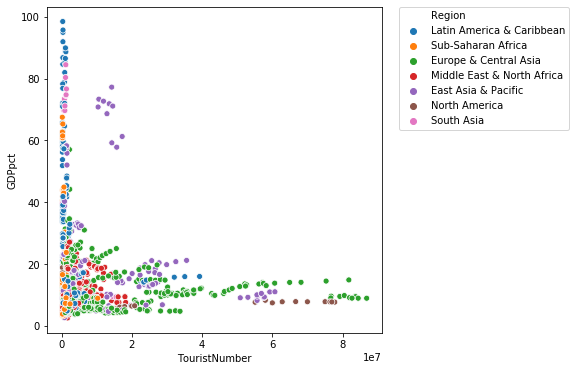

In [45]:
yrs  = filtereddata[filtereddata['Year'] > '2007-01-01']
fig = plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="TouristNumber", y="GDPpct", data=yrs,hue="Region")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

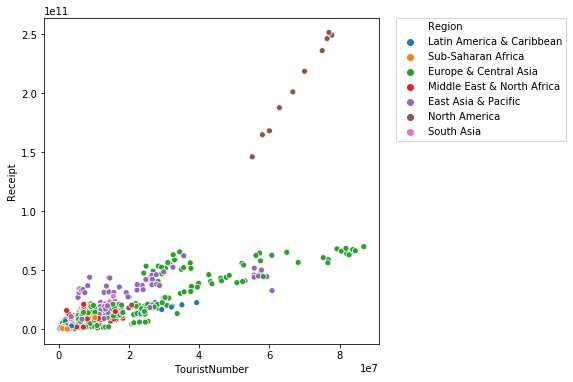

In [46]:
fig = plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="TouristNumber", y="Receipt", data=yrs,hue="Region")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

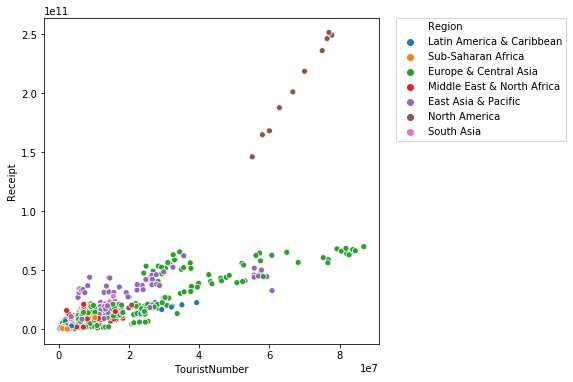

In [47]:
fig = plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="TouristNumber", y="Receipt", data=yrs,hue="Region")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

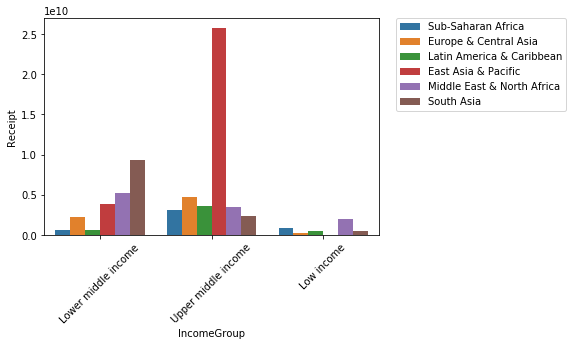

In [48]:
ax = sns.barplot(x="IncomeGroup", y="Receipt", data=yrs[yrs["IncomeGroup"] != "High income"],ci=None,hue='Region')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

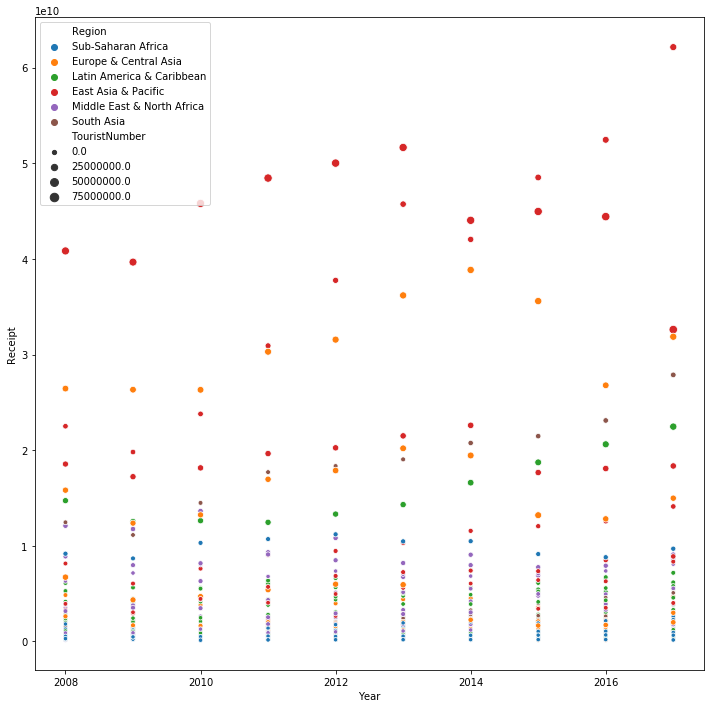

In [49]:
fig = plt.figure(figsize=(12,12))
ax = sns.scatterplot(x=yrs["Year"].dt.year, y="Receipt", data=yrs[yrs["IncomeGroup"] != "High income"],hue="Region", size="TouristNumber")

plt.show()

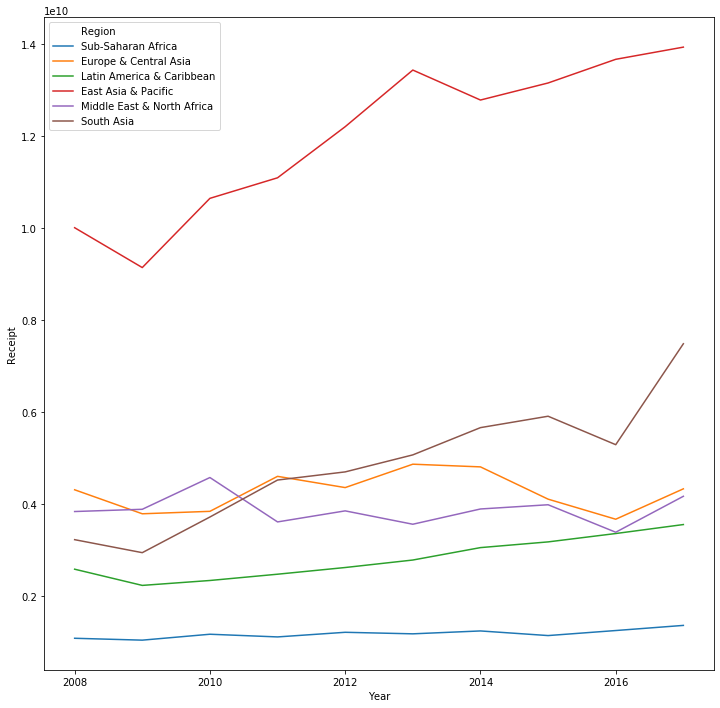

In [52]:
fig = plt.figure(figsize=(12,12))
ax = sns.lineplot(x=yrs["Year"].dt.year, y="Receipt", data=yrs[yrs["IncomeGroup"] != "High income"],ci=None, hue="Region")

In [53]:
#filter the data by both Income Group and Region set in the list variables to focus our analysis
income_filter=['Upper middle income']
region_filter =['East Asia & Pacific']
incomefilter=filtereddata.loc[filtereddata['IncomeGroup'].isin(income_filter)]['Country Code']
regionfilter=filtereddata.loc[filtereddata['Region'].isin(region_filter)]['Country Code']
bothfilter=set(incomefilter.values).intersection(set(regionfilter.values))
print("Focus countries:{}".format(bothfilter))
filtered_country_df=filtereddata[filtereddata['Country Code'].isin(bothfilter)]
filtered_country_df.describe()

Focus countries:{'FJI', 'THA', 'MYS', 'CHN'}


,TouristNumber,Receipt,Population,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
count,7.200000e+01,7.200000e+01,7.200000e+01,72.000000,72.000000,7.200000e+01,72.000000,7.200000e+01
mean,2.219374e+07,1.972181e+10,3.553114e+08,7.959737,19.203036,1.224427e+06,5.288163,2.565947e+07
std,1.898724e+07,1.687050e+10,5.654875e+08,1.739274,10.456504,2.268850e+06,4.452541,4.323711e+07
min,2.940000e+05,2.910000e+08,8.110060e+05,5.000000,8.237930,1.000000e+04,1.652370,8.000000e+04
25%,7.395000e+06,4.701750e+09,1.761506e+07,6.518225,12.245100,2.750000e+04,2.422312,2.310341e+06
50%,1.838850e+07,1.801650e+10,4.702884e+07,8.000000,15.160750,9.755800e+04,3.252425,5.278970e+06
75%,3.264000e+07,3.134725e+10,3.675686e+08,10.000000,22.922450,7.260737e+05,6.116263,1.515688e+07
max,6.074000e+07,6.215800e+10,1.386395e+09,11.000000,40.553700,9.030130e+06,13.186800,1.546660e+08


    Explained_Var  Cumulative_Var
PC                               
1            65.9           65.92
2            18.2           84.08
3             8.8           92.86
4             4.7           97.53
5             1.5           99.02
6             0.4           99.45
7             0.3           99.76
8             0.2          100.00


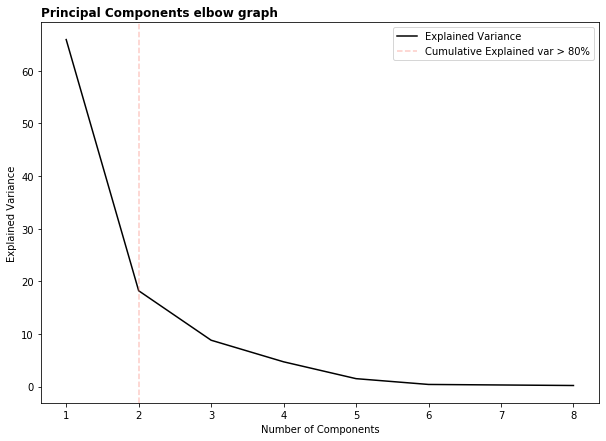

[5.3 1.5 0.7 0.4 0.1 0.  0.  0. ]
     TouristNumber   Receipt  Population  StartupSteps    GDPpct   GDPgovt  \
PC1       0.428298  0.365577    0.381854     -0.263454 -0.343404  0.376754   
PC2       0.000568 -0.137088    0.296114      0.026187  0.455994  0.360626   
PC3      -0.063780  0.048039   -0.052572     -0.941398  0.133671 -0.170262   
PC4       0.142578  0.833988   -0.315262      0.147599  0.375569 -0.068621   
PC5      -0.144186 -0.156817   -0.716191     -0.143446  0.071206  0.445722   
PC6       0.258867 -0.111222   -0.090133     -0.002966  0.038775 -0.697173   
PC7       0.836705 -0.324780   -0.217227      0.011445  0.176018  0.097176   
PC8       0.065469  0.085285   -0.310015      0.034281 -0.691134  0.012072   

     GDPgovtpct    GDPcap  
PC1   -0.246491  0.383491  
PC2    0.665360  0.334892  
PC3    0.160934 -0.178534  
PC4    0.116410 -0.060403  
PC5   -0.208166  0.417183  
PC6    0.040935  0.650581  
PC7    0.019412 -0.326069  
PC8    0.641640 -0.040507  

 PCA is no

In [55]:
#perform PCA on the filtered country data
# Normalize
clust = filtered_country_df.copy().drop(columns=["Country Name",'Country Code','Year',"Region","IncomeGroup"])

scaler = StandardScaler()

clust = scaler.fit_transform(clust)

clust = pd.DataFrame(clust, columns =filtered_country_df.drop(columns=["Country Name",'Country Code','Year',"Region","IncomeGroup"]).columns)

n_components = clust.shape[1]

pca = PCA(n_components= n_components)

principalComponents = pca.fit_transform(clust)

# Explained variance by each component

pca_board = pd.DataFrame({"Explained_Var":np.round(pca.explained_variance_ratio_*100,decimals=1),
                          "Cumulative_Var":np.round(np.cumsum(pca.explained_variance_ratio_*100),decimals= 2)})
pca_board.index.name = 'PC'
pca_board.index += 1 

print (pca_board)

#elbow graph
plt.figure(figsize=(10,7))
plt.plot(pca_board.Explained_Var, color = "black", label = "Explained Variance")
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title ("Principal Components elbow graph", loc = "left",fontweight = "bold")
plt.axvline(x = 2, alpha = 0.4, color = "salmon", linestyle = "--", label = "Cumulative Explained var > 80%")
plt.legend()
plt.show()

print(np.round(pca.explained_variance_,decimals=1))

'''2 components'''

# Revert PCA effect
# pca.inverse_transform(principalComponents)

pca_index= []

for i in range(1,n_components+1):
    pca_index.append('PC'+str(i))
    
print (pd.DataFrame(pca.components_,
                    columns=clust.columns,
                    index = pca_index))


agg_pca = pd.DataFrame(principalComponents,
                     columns = pca_index)


print("\n PCA is not a good option")

In [56]:
# finding the optimal number of clusters

def elbow_plot(data,max_k):
    # elbow
    cluster_range = range(1,max_k)
    cluster_errors = []
    sse = {}
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, 
                    random_state=0,
                    n_init = 10,
                    max_iter = 300).fit(data)
        data["Clusters"] = kmeans.labels_
        #print(data["clusters"])
        sse[k] = kmeans.inertia_
        cluster_errors.append(kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure(figsize=(8,5))
    plt.plot(list(sse.keys()), list(sse.values()),
             linewidth=1.5,
             linestyle="-",
             marker = "X",
             markeredgecolor="salmon",
             color = "black")
    plt.title ("K-Means elbow graph", loc = "left",fontweight = "bold")
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.axvline(x = 3, alpha = 0.4, color = "salmon", linestyle = "--")
    plt.show()
    clusters_df = pd.DataFrame({"cluster_errors":cluster_errors})
    clusters_df.index += 1
    clusters_df.index.name = "num_clusters"
    print (clusters_df)

#finding best initialisation method
def compare_init_methods(data,list_init_methods,K_n):
    keys=[]
    centroids_list=[]
    labels_list=[]
    for i in range(1,5):
        fig, axs = plt.subplots(len(list_init_methods), 2, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
        fig.suptitle('Initialization Method Comparision nr {}'.format(i))

        for index, init_method in enumerate(list_init_methods):
            centroids, labels = kmeans2(data, k=K_n,minit=init_method)
            keys.append("{}:{}".format(i,init_method))
            centroids_list.append(centroids)
            labels_list.append(labels)
            axs[index, 0].plot(data[labels == 0, 0], data[labels == 0, 1], 'ob',
                 data[labels == 1, 0], data[labels == 1, 1], 'or',
                 data[labels == 2, 0], data[labels == 2, 1], 'oy')
            axs[index, 0].plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=5)


            axs[index, 1].plot(data[labels == 0, 2], data[labels == 0, 3], 'ob',
                 data[labels == 1, 2], data[labels == 1, 3], 'or',
                 data[labels == 2, 2], data[labels == 2, 3], 'oy')
            axs[index, 1].plot(centroids[:, 2], centroids[:, 3], 'sg', markersize=5)
            axs[index, 0].set_title("Method:{}".format(init_method), y=0.7)
    return keys, centroids_list, labels_list

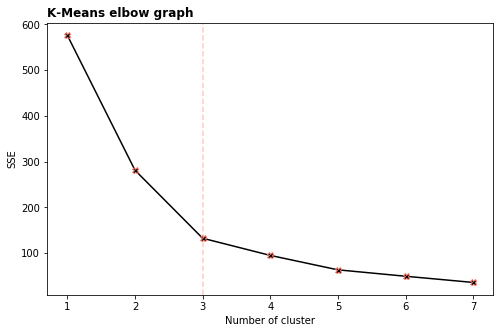

              cluster_errors
num_clusters                
1                 576.000000
2                 281.083119
3                 132.371028
4                  94.813395
5                  63.279274
6                  49.238721
7                  35.686255


In [57]:
#run elbow plot for range of k_max
k_max = 8
elbow_plot(clust,k_max)

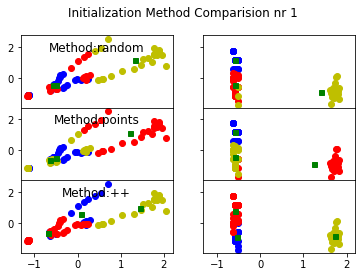

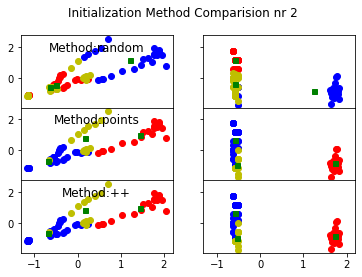

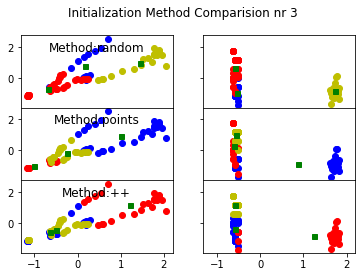

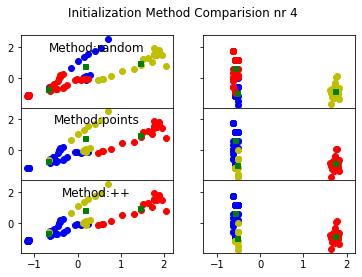

In [58]:
#run different initialisation methods and optimal k value(elbow)

init_methods = ['random','points','++']
number_K=3

keys, centroids_list, labels_list = compare_init_methods(clust.iloc[:,0:4].values,init_methods,number_K)

In [59]:
#pick best kmeans iteration and initialisation method
best_init=4
best_method="points"
centroids_dict=dict(zip(keys,centroids_list))
labels_dict =dict(zip(keys,labels_list))
print(labels_dict["{}:{}".format(best_init,best_method)], centroids_dict["{}:{}".format(best_init,best_method)])

[1 0 0 2 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 1 0 0 0 1 0 2 2 1 0 2 2 1 0 2 2 1 0 2 2 1 0 2 2 1 0 0 2 1 0 0 2] [[-0.6877277  -0.68048641 -0.58865406  0.66768746]
 [ 1.44666827  0.97018965  1.72962389 -0.84180721]
 [ 0.16590823  0.80280991 -0.53833949 -0.9402043 ]]


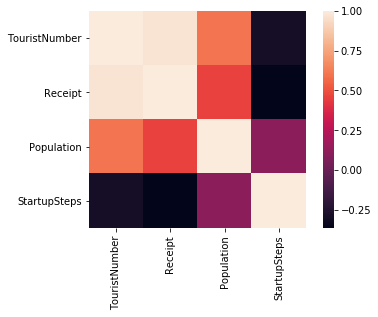

In [61]:
merged_region_df_cr = merged_region_df[['Country Name','TouristNumber','Receipt','Population', 'StartupSteps']] #Subsetting the data
cor = merged_region_df_cr.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

In [66]:
fig = go.Figure(data=go.Choropleth(
    locations = merged_country_df['Country Code'],
    z = merged_country_df['TouristNumber'],
    text = merged_country_df['Country Name'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Tourist<br>Number',
))

fig.update_layout(
    title_text='Tourist Number',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        showarrow = False
    )]
)

fig.show()

In [67]:
#filter the data by both Income Group and Region set in the list variables to focus our analysis
income_filter=['Upper middle income']
region_filter =['South Asia']
incomefilter=filtereddata.loc[filtereddata['IncomeGroup'].isin(income_filter)]['Country Code']
regionfilter=filtereddata.loc[filtereddata['Region'].isin(region_filter)]['Country Code']
bothfilter=set(incomefilter.values).intersection(set(regionfilter.values))
print("Focus countries:{}".format(bothfilter))
filtered_country_df=filtereddata[filtereddata['Country Code'].isin(bothfilter)]
filtered_country_df.describe()

Focus countries:{'MDV', 'LKA'}


,TouristNumber,Receipt,Population,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
count,3.600000e+01,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000
mean,8.471222e+05,1.608306e+09,1.019980e+07,7.337979,33.262451,22777.777778,9.636185,363276.916667
std,4.762988e+05,1.247943e+09,9.989488e+06,1.859507,28.844725,13007.934087,5.310748,291270.248937
min,3.370000e+05,3.210000e+08,2.793980e+05,5.000000,6.859420,10000.000000,4.289810,30000.000000
25%,4.917500e+05,7.240000e+08,3.509115e+05,6.000000,9.229823,10000.000000,4.408432,109399.750000
50%,6.550000e+05,1.328000e+09,9.637002e+06,7.000000,14.091750,20000.000000,9.482115,226123.500000
75%,1.145000e+06,2.443000e+09,2.001886e+07,9.000000,69.653250,30000.000000,14.861350,628095.000000
max,2.116400e+06,5.083000e+09,2.144400e+07,12.030710,84.480500,50000.000000,15.287000,938008.000000


In [68]:
merged_region_df.groupby('Country Name').Receipt.mean()

Country Name
Arab World                                              5.713004e+10
Caribbean small states                                  7.515191e+09
Central Europe and the Baltics                          4.272022e+10
Early-demographic dividend                              1.328415e+11
East Asia & Pacific                                     2.274951e+11
East Asia & Pacific (IDA & IBRD countries)              9.886516e+10
East Asia & Pacific (excluding high income)             9.890417e+10
Euro area                                               2.934506e+11
Europe & Central Asia                                   4.596061e+11
Europe & Central Asia (IDA & IBRD countries)            7.144070e+10
Europe & Central Asia (excluding high income)           5.358655e+10
European Union                                          3.896566e+11
Fragile and conflict affected situations                1.412126e+10
Heavily indebted poor countries (HIPC)                  9.757960e+09
High income          

# Spectral Clustering

Deciding a set of countries to start the cluster analysis

Based on the following chart, it's possible to determine that Europe & Central Asia has a stable ascending trend during the last years besides the other regions, which is a good indicator for investment. 

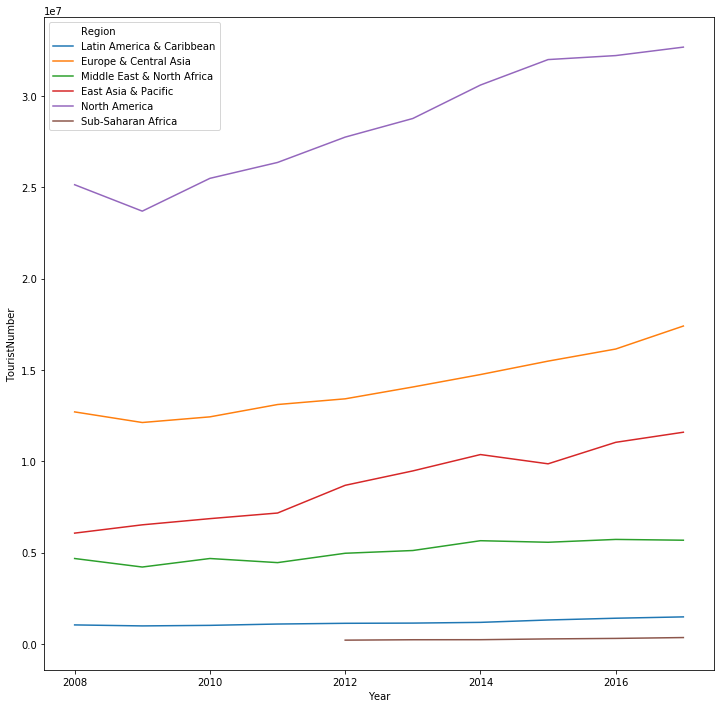

In [226]:
# Plotting the number of tourist arraivals per region, 
# only on high income countries

fig = plt.figure(figsize=(12,12))
ax = sns.lineplot(x = yrs["Year"].dt.year, 
                  y = "TouristNumber", 
                  data = yrs[yrs["IncomeGroup"] == "High income"],
                  ci = None, 
                  hue = "Region")

Filter the dataset according to the previous decision and showing the set of countries selected for the cluster analysis, by their corresponding country code.

In [228]:
# Filtering the data by both Income Group and Region
income_filter = ['High income']    # Upper middle income, High income
region_filter = ['Europe & Central Asia']    # East Asia & Pacific, Europe & Central Asia

incomefilter = filtereddata.loc[filtereddata['IncomeGroup'].isin(income_filter)]['Country Code']
regionfilter = filtereddata.loc[filtereddata['Region'].isin(region_filter)]['Country Code']
bothfilter = set(incomefilter.values).intersection(set(regionfilter.values))

# Print selected countries codes
print("Focus countries:{}".format(bothfilter))

# Define a pandas DataFrame with the filtered information
filtered_country_df = filtereddata[filtereddata['Country Code'].isin(bothfilter)]
filtered_country_df.describe()

Focus countries:{'ESP', 'LVA', 'PRT', 'AND', 'MCO', 'DEU', 'IRL', 'ITA', 'FIN', 'NLD', 'AUT', 'NOR', 'DNK', 'CYP', 'LUX', 'FRA', 'SVN', 'GRC', 'POL', 'SWE', 'EST', 'ISL', 'SVK', 'CHE', 'BEL', 'LTU', 'HRV', 'GBR', 'CZE', 'HUN'}


,TouristNumber,Receipt,Population,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
count,5.380000e+02,5.380000e+02,5.380000e+02,538.000000,538.000000,5.380000e+02,538.000000,5.380000e+02
mean,1.304352e+07,1.359482e+10,1.622979e+07,6.611647,12.325121,4.097933e+05,3.589775,5.096628e+06
std,1.834317e+07,1.704595e+10,2.241420e+07,2.440422,8.107406,6.028445e+05,5.964868,7.821021e+06
min,2.350000e+05,1.530000e+08,3.214700e+04,2.000000,3.543320,0.000000e+00,0.000000,1.000000e+04
25%,2.164750e+06,2.468750e+09,2.204833e+06,5.000000,7.240238,3.991848e+04,0.561217,4.797613e+05
50%,6.394000e+06,6.856500e+09,7.207052e+06,6.000000,9.928785,1.666455e+05,1.312425,2.097365e+06
75%,1.489625e+07,1.557625e+10,1.109813e+07,8.000000,14.729100,4.510425e+05,3.635317,4.272538e+06
max,8.686100e+07,6.989400e+10,8.265700e+07,15.000000,57.051873,2.339530e+06,27.588869,4.357110e+07


Step 1: Importing the required libraries

In [229]:
# import pandas as pd 
# import matplotlib.pyplot as plt 
from sklearn.cluster import SpectralClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score 

Step 2: Loading and Cleaning the Data

In [230]:
# Loading the data
X = filtered_country_df 
  
# Dropping non-numeric columns 
X = X.drop(['Country Name',
            'Country Code',
            'Year',
            'Region',
            'IncomeGroup'],
            axis = 1) 

# Showing the cleaned data stored in X
X.head()

,TouristNumber,Receipt,Population,StartupSteps,GDPpct,GDPgovt,GDPgovtpct,GDPcap
3,2949000.0,2.899709e+08,65390.0,7.246149,24.741937,8716.440527,7.081787,3.200254e+04
11,17982000.0,1.138200e+10,8011566.0,4.705915,15.193900,336739.000000,0.875186,4.763250e+06
14,6457000.0,6.592000e+09,10251250.0,4.715364,8.581170,288065.000000,0.578979,3.161700e+06
34,7821000.0,8.988000e+09,7184250.0,6.758284,10.492900,414499.000000,1.152660,4.733100e+06
49,2686000.0,2.098696e+09,943290.0,6.516390,31.098700,30000.000000,8.808690,3.879010e+05


Step 3: Determine the number of components needed to explain a reasonable percentage of the total variance using Principal Components Analysis (PCA).

In [231]:
# Scaling the Data 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
# Normalizing the Data 
X_normalized = normalize(X_scaled) 

# Fitting the PCA algorithm with our Data
pca = PCA().fit(X_scaled)

# Showing the percentage explained by each compomonent and 
# and the cumulative sum of this percentage on a table
pca_board = pd.DataFrame({"Explained var. (%)":np.round(pca.explained_variance_ratio_*100, decimals = 1),
                          "Cumulative var. (%)":np.round(np.cumsum(pca.explained_variance_ratio_*100), decimals = 2)})
pca_board.index.name = 'PC'
pca_board.index += 1 

print (pca_board)

    Explained var. (%)  Cumulative var. (%)
PC                                         
1                 58.3                58.27
2                 22.1                80.41
3                  9.9                90.30
4                  3.9                94.17
5                  2.5                96.72
6                  1.7                98.46
7                  1.1                99.55
8                  0.5               100.00


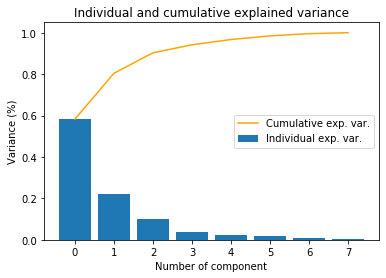

In [232]:
# Plotting the Cumulative Sum of the Explained Variance
plt.figure()

plt.plot(np.cumsum(pca.explained_variance_ratio_), 
         color = 'orange', 
         label = 'Cumulative exp. var.')

x_pos = np.arange(len(pca.explained_variance_ratio_))
plt.bar(x_pos,pca.explained_variance_ratio_,        
        label = 'Individual exp. var.')

plt.xlabel('Number of component')
plt.ylabel('Variance (%)') # for each component
plt.title('Individual and cumulative explained variance')
plt.legend(loc = 'center right', frameon = True)
plt.show()


Step 4: Preprocessing the data (reducing dimmensions) to make it visualizable with PCA, based on the step 3 conclusions

In [233]:
# Reducing the dimensions of the data with PCA
n_PC = 2  # Define the numbers of components
pca = PCA(n_components = n_PC) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['PC' + str(x) for x in range(1,n_PC + 1)] 
  
X_principal.head() 

,PC1,PC2
0,-0.205292,0.775604
1,-0.033047,-0.387093
2,-0.482676,-0.578935
3,-0.364371,-0.115487
4,-0.052680,0.710936


Step 5: Determine the number of clusters

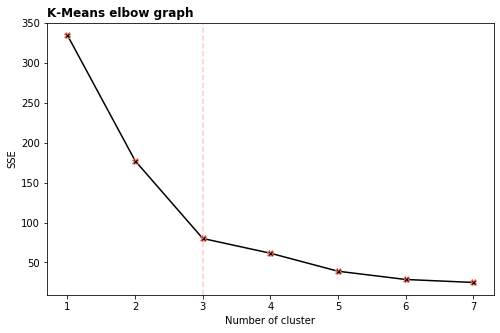

              cluster_errors
num_clusters                
1                 334.564545
2                 177.414782
3                  80.040140
4                  61.554570
5                  39.013792
6                  28.655291
7                  24.940833


In [234]:
# Showing scree plot to determine the correct number of clusters
elbow_plot(X_principal,8)

Step 6: Building the Clustering models and Visualizing the clustering.

The Spectral Clustering Method can be developed with 2 types of affinity.
We will use both types and compare the results to choose the best

a) Using affinity = ‘rbf’

Kernel of the euclidean distanced

In [235]:
# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = 3, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(X_principal)

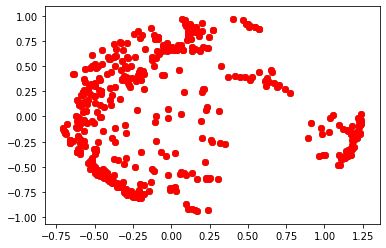

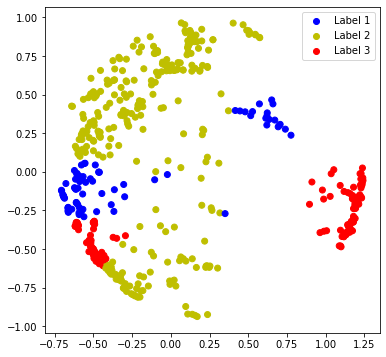

In [236]:
# Building the label to colour mapping 
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels_rbf] 
  
# Plotting the clustered scatter plot 
  
b = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='b'); 
y = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='y');
r = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='r');
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['PC1'], X_principal['PC2'], c = cvec) 
plt.legend((b, y, r), ('Label 1', 'Label 2','Label 3'))

plt.show() 

b) Using affinity = ‘nearest_neighbors’

In [239]:
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = 3, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_principal) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



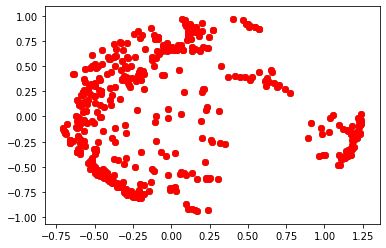

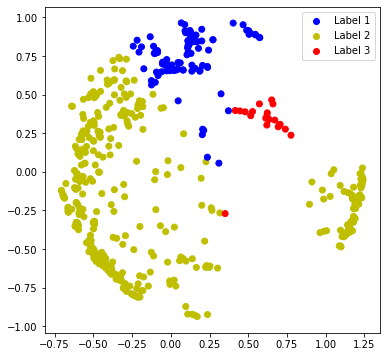

In [243]:
# Building the label to colour mapping 
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels_nn] 
  
# Plotting the clustered scatter plot 
  
b = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='b'); 
y = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='y');
r = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='r');
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['PC1'], X_principal['PC2'], c = cvec) 
plt.legend((b, y, r), ('Label 1', 'Label 2','Label 3'))

plt.show() 

Step 7: Evaluating and comparing the performances of both affinity methods

In [241]:
# List of different values of affinity 
affinity = ['rbf', 'nearest-neighbours'] 
  
# List of Silhouette Scores 
s_scores = [] 
  
# Evaluating the performance 
s_scores.append(silhouette_score(X, labels_rbf)) 
s_scores.append(silhouette_score(X, labels_nn)) 
  
print(s_scores) 

[-0.02433463260992284, -0.32686612108043117]


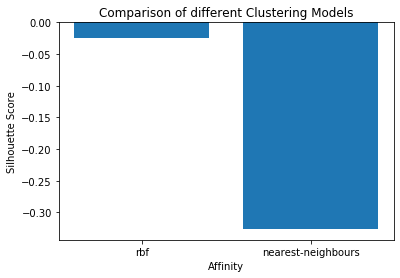

In [242]:
# Plotting a Bar Graph to compare the models 
plt.bar(affinity, s_scores) 
plt.xlabel('Affinity') 
plt.ylabel('Silhouette Score') 
plt.title('Comparison of different Clustering Models') 
plt.show() 

Acording to Peter Rousseeuw[1], silhouette shows which objects lie well within their cluster, and which ones are merely somewhere in between clusters. The silhouette scores s(i) are measured on the following range of values: 
-1 <= s(i) <= 1

Being breve about this values:
a silhouette score close to 1 means 'well-clustered’
a silhouette score close to 0 is considered as 'intermediate case’
a silhouette score close to -1 means 'misclassified’

[1] Silhouettes: A graphical aid to the interpretation and validation of cluster analysis https://www.sciencedirect.com/science/article/pii/0377042787901257?via%3Dihub